# Predicting Best Picture Winners & Nominees
*An Analysis by Sean Osier*

### Regression

In [64]:
# Import Dependencies
import pickle
import random
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd
import numpy as np

# import csv
# from collections import defaultdict
# import dateutil.parser

# For display
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# Pickling functions
def pickle_it(data, filename, python_version=3):
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile, protocol=python_version)

def load_pickle(filename):
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

In [56]:
to_regress_raw = load_pickle("df_for_regression.pkl")

In [57]:
to_regress_raw.head(1)

,key,user_rating_short,runtime,pg_rating,status_year,status_score,num_nominees,director_martin_scorsese,director_quentin_tarantino,director_steven_spielberg,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci_fi,genre_sport,genre_thriller,genre_war,genre_western
0,Inception (2010),8.8,148,PG_13,2010,5,>5,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [58]:
def get_random_years_from_range(years, years_to_pick):
    test_years = random.sample(years, years_to_pick)
    print(test_years)
    
years = range(1990, 2015)
# get_random_years_from_range(range(1990, 2015), 5)  # Returned the below:
test_years = [1993, 2001, 2012, 2004, 2005]
train_years = list(set(years) - set(test_years))
test_years = [str(year) for year in test_years]
train_years = [str(year) for year in train_years]

In [59]:
test_criterion = to_regress_raw["status_year"].map(lambda x: x in test_years)
train_criterion = to_regress_raw["status_year"].map(lambda x: x in train_years)

to_test_raw = to_regress_raw[test_criterion]
to_train_raw = to_regress_raw[train_criterion]

In [60]:
def get_Y_Xs_for_regression(for_regression_raw_data):
    columns = list(for_regression_raw_data.columns.values)
    x_columns = columns[1:4] + columns[6:]
    
    x_string = ""
    for column in x_columns:
        x_string += column + " + "
    x_string = x_string[:-2]
    
    patsy_string = "status_score ~ " + x_string
    
    y, X = dmatrices(patsy_string, data=for_regression_raw_data, return_type='dataframe')
    return y, X

In [61]:
y_train, X_train = get_Y_Xs_for_regression(to_train_raw)

In [63]:
X_train.head()

,Intercept,pg_rating[T.NC_17],pg_rating[T.PG],pg_rating[T.PG_13],pg_rating[T.R],pg_rating[T.UNRATED],num_nominees[T.>5],user_rating_short,runtime,director_martin_scorsese,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci_fi,genre_sport,genre_thriller,genre_war,genre_western
0,1,0,0,1,0,0,1,8.8,148,0,...,0,0,0,1,0,1,0,1,0,0
1,1,0,0,1,0,0,1,6.8,103,0,...,1,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,8.1,138,1,...,0,0,0,1,0,0,0,1,0,0
3,1,0,0,1,0,0,1,7.5,112,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,1,7.7,95,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
def run_linear_regression(y, Xs):
    model = sm.OLS(y, Xs)
    results = model.fit()
    return results

In [66]:
test = run_linear_regression(y_train, X_train)
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           status_score   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     64.62
Date:                Tue, 06 Oct 2015   Prob (F-statistic):               0.00
Time:                        13:34:23   Log-Likelihood:                -5027.0
No. Observations:               54094   AIC:                         1.037e+04
Df Residuals:                   53934   BIC:                         1.180e+04
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.0524      0.019     -2.777      0.005        -0.089    -0.015
pg_rating[T.NC_17]                      -0.0480      0.035     -1.359      0.174        -0.117     0.021
pg_rating[T.PG]                         -0.0358      0.018     -1.959      0.050        -0.072  1.07e-05
pg_rating[T.PG_13]                       0.0059      0.018      0.328      0.743        -0.030     0.041
pg_rating[T.R]                          -0.0058      0.018     -0.331      0.740        -0.040     0.029
pg_rating[T.UNRATED]                    -0.0344      0.017     -1.991      0.047        -0.068    -0.001
num_nominees[T.>5]                       0.0048      0.002      2.008      0.045         0.000     0.009
user_rating_short                        0.0080      0.001      8.200      0.000         0.006     0.010
runtime                                  0.0004   6.04e-05      6.773      0.000         0.000     0.001
director_martin_scorsese                 2.4900      0.091     27.464      0.000         2.312     2.668
director_quentin_tarantino               1.5574      0.110     14.165      0.000         1.342     1.773
director_steven_spielberg                0.5161      0.092      5.621      0.000         0.336     0.696
director_christopher_nolan               0.3246      0.106      3.074      0.002         0.118     0.532
director_alfred_hitchcock             2.073e-16   2.18e-15      0.095      0.924     -4.06e-15  4.48e-15
director_david_fincher                   0.6539      0.088      7.464      0.000         0.482     0.826
director_stanley_kubrick                -0.5496      0.279     -1.973      0.049        -1.096    -0.004
director_james_cameron                   3.4906      0.136     25.729      0.000         3.225     3.757
director_clint_eastwood                  1.2495      0.086     14.534      0.000         1.081     1.418
director_peter_jackson                   1.7672      0.095     18.646      0.000         1.581     1.953
director_francis_ford_coppola            0.4762      0.102      4.672      0.000         0.276     0.676
director_ridley_scott                    0.4085      0.081      5.043      0.000         0.250     0.567
director_woody_allen                     0.0744      0.066      1.126      0.260        -0.055     0.204
director_david_lynch                    -0.0301      0.109     -0.277      0.782        -0.244     0.183
director_paul_thomas_anderson            0.5086      0.114      4.468      0.000         0.286     0.732
director_akira_kurosawa                 -0.0171      0.188     -0.091      0.928        -0.386     0.352
director_tim_burton                     -0.1977      0.095     -2.078      0.038        -0.384    -0.011
director_sergio_leone                -

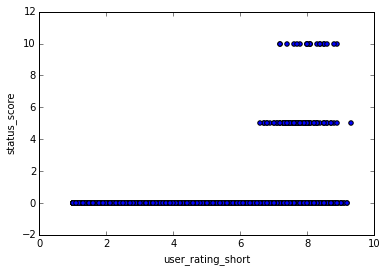

In [72]:
to_train_raw.plot(kind="scatter", x="user_rating_short", y="status_score")

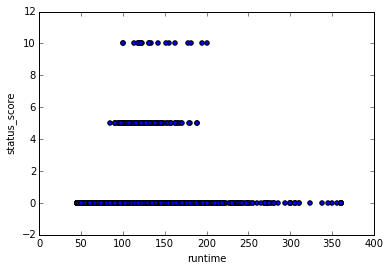

In [73]:
to_train_raw.plot(kind="scatter", x="runtime", y="status_score")

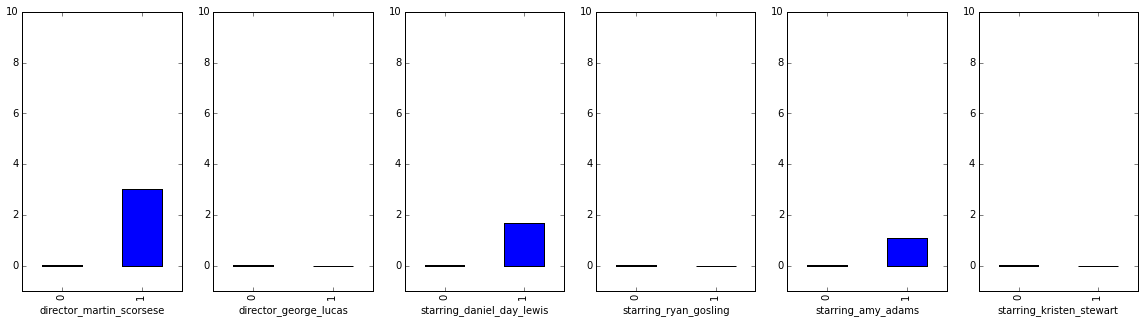

In [125]:
def plot_boolean(param, n):
    grouped = to_train_raw.groupby(param)
    to_plot = grouped["status_score"].mean()
    to_plot.plot(kind="bar", ylim=(-1,10), ax=axes[n], figsize=(20, 5))
    
fig, axes = plt.subplots(nrows=1, ncols=6)
plot_boolean("director_martin_scorsese", 0)
plot_boolean("director_george_lucas", 1)
plot_boolean("starring_daniel_day_lewis", 2)
plot_boolean("starring_ryan_gosling", 3)
plot_boolean("starring_amy_adams", 4)
plot_boolean("starring_kristen_stewart", 5)